## Hipótesis:
**La presencia de personajes principales femeninos ha aumentado en el cine español a lo largo de los años.**

Asumimos que "aumentar" significa que la tendencia temporal presenta una pendiente positiva y un p-valor menor a 0.05 (confianza del 95%).

### **0. INSTALAR E IMPORTAR LAS LIBRERÍAS NECESARIAS**

In [524]:
''' Instalar librerías si es necesario'''
! pip install hampel
! pip install pmdarima

In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from itertools import combinations
from hampel import hampel
import pmdarima as pm
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

### **1. CARGA DEL DATASET Y PREPARACIÓN DE DATOS**

In [526]:
df = pd.read_csv("df_entrega_2.csv")
df["year"] = df["year"].astype(int)

df.head()

,id,year,lustrum,count_by_lustrum,duration_minutes,genre,genre_simplified,word_plot_count,media_sentiment,topics_lustrum_keywords,count_female,count_male,female_presence,female_ratio,female_adj_percentage
0,350295e9-aad9-4160-8e09-0d44221e32b6,2025,2025,64,123,Drama,Drama,66,NEG,"Tópico 0: familia, joven, guerra, ven, vida, d...",3,0,1,1.000000,71.428571
1,f0b76aa5-3018-4279-b0dd-c8333b16ad6f,2025,2025,64,126,Drama histórico,Drama,55,POS,"Tópico 0: familia, joven, guerra, ven, vida, d...",1,2,1,0.333333,71.428571
2,0ad46be2-3fcf-4bd8-9ed0-a48e79a64612,2025,2025,64,80,Documental,Documental,46,NEG,"Tópico 0: familia, joven, guerra, ven, vida, d...",1,1,1,0.500000,33.333333
3,a009e701-a94f-4834-bedf-a4dd5aa98f75,2025,2025,64,84,Drama biográfico,Drama,84,NEU,"Tópico 0: familia, joven, guerra, ven, vida, d...",0,1,0,0.000000,50.000000
4,e0bdeb7c-6423-4b99-a441-66ca63057360,2025,2025,64,92,AventurasCatástrofesDrama romántico,Drama,63,POS,"Tópico 0: familia, joven, guerra, ven, vida, d...",1,1,1,0.500000,16.666667



Análisis anual y por lustro de las variables más relevantes generando tablas con los siguientes indicadores:

- female_presence_mean: proporción media de películas con presencia femenina (media de female_presence).

- female_ratio_mean: media anual del female_ratio.

- female_adj_mean: media anual del female_adj_percentage.

- n_films: número de películas por año (incluido como variable de contexto).

In [527]:
IND_BIN   = "female_presence"
IND_RATIO = "female_ratio"
IND_ADJ   = "female_adj_percentage"

# Procesamiento Anual
yearly = (
    df.groupby("year")
      .agg(
          female_presence_mean=("female_presence", "mean"),
          female_ratio_mean=("female_ratio", "mean"),
          female_adj_mean=("female_adj_percentage", "mean"),
          n_films=("id", "count")
      )
      .reset_index()
)

# Asegurar continuidad anual e interpolar
full_years = pd.DataFrame({"year": range(1940, 2026)})
yearly = pd.merge(full_years, yearly, on="year", how="left")
yearly["female_ratio_mean"] = yearly["female_ratio_mean"].interpolate(method='linear')
yearly["female_adj_mean"] = yearly["female_adj_mean"].interpolate(method='linear')

# Indexación temporal anual
yearly["date"] = pd.to_datetime(yearly["year"], format="%Y")
yearly.set_index("date", inplace=True)
yearly.index.freq = 'YS'

# Procesamiento por lustro
agg_lustrum = (
    df.groupby("lustrum")
      .agg(
          female_presence_mean=("female_presence", "mean"),
          female_ratio_mean=("female_ratio", "mean"),
          female_adj_mean=("female_adj_percentage", "mean"),
          n_films=("id", "count")
      )
      .reset_index()
)

# Indexación temporal por lustros
agg_lustrum["date"] = pd.to_datetime(agg_lustrum["lustrum"], format="%Y")
agg_lustrum.set_index("date", inplace=True)

# Definimos frecuencia de 5 años
agg_lustrum.index.freq = '5YS'

# Creación de series
series_ratio = yearly["female_ratio_mean"]
series_lustrum_ratio = agg_lustrum["female_ratio_mean"]
series_bin = yearly.set_index("year")["female_presence_mean"]
series_lustrum_bin = agg_lustrum["female_presence_mean"]
series_adj = yearly.set_index("year")["female_adj_mean"]
series_lustrum_adj = agg_lustrum["female_adj_mean"]

print("Índice Anual (primeros 3):", yearly.index[:3])
print("Índice Lustros (primeros 3):", agg_lustrum.index[:3])

Índice Anual (primeros 3): DatetimeIndex(['1940-01-01', '1941-01-01', '1942-01-01'], dtype='datetime64[ns]', name='date', freq='YS-JAN')
Índice Lustros (primeros 3): DatetimeIndex(['1940-01-01', '1945-01-01', '1950-01-01'], dtype='datetime64[ns]', name='date', freq='5YS-JAN')


In [528]:
# Agregación anual
yearly.head()

,year,female_presence_mean,female_ratio_mean,female_adj_mean,n_films
date,,,,,
1940-01-01,1940,0.625000,0.314881,36.979167,8
1941-01-01,1941,0.461538,0.271795,48.280053,13
1942-01-01,1942,0.600000,0.302247,37.542476,15
1943-01-01,1943,0.650000,0.427511,42.559524,20
1944-01-01,1944,0.785714,0.462121,38.820615,14


In [529]:
# Agregación por lustro
agg_lustrum.head()

,lustrum,female_presence_mean,female_ratio_mean,female_adj_mean,n_films
date,,,,,
1940-01-01,1940,0.628571,0.365800,41.161289,70
1945-01-01,1945,0.590361,0.336704,32.411330,83
1950-01-01,1950,0.569106,0.307011,38.606035,123
1955-01-01,1955,0.433824,0.222810,31.333190,136
1960-01-01,1960,0.559633,0.293397,40.670240,218


### **2. VISUALIZACIONES TEMPORALES**

Evolución temporal de los indicadores más relevantes para nuestra hipótesis a lo largo de los años.

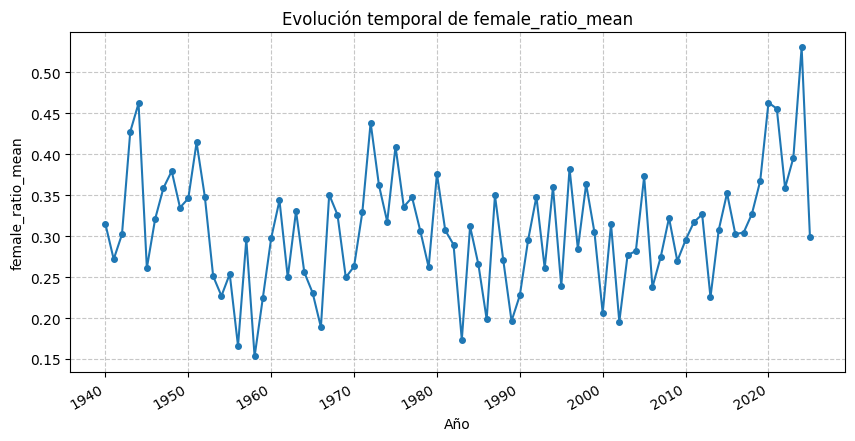

In [530]:
plt.figure(figsize=(10, 5))
plt.plot(series_ratio.index, series_ratio.values, marker="o", linestyle="-", markersize=4)
plt.title("Evolución temporal de female_ratio_mean")
plt.xlabel("Año")
plt.ylabel("female_ratio_mean")
plt.gcf().autofmt_xdate()

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

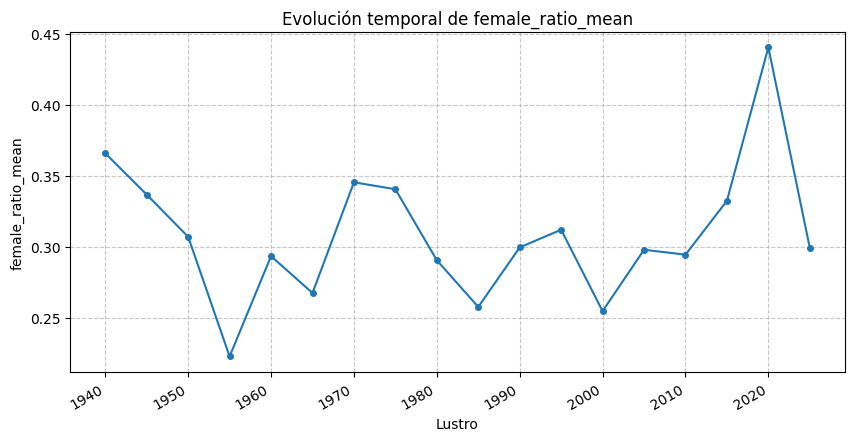

In [531]:
plt.figure(figsize=(10, 5))
plt.plot(series_lustrum_ratio.index, series_lustrum_ratio.values, marker="o", linestyle="-", markersize=4)
plt.title("Evolución temporal de female_ratio_mean")
plt.xlabel("Lustro")
plt.ylabel("female_ratio_mean")
plt.gcf().autofmt_xdate()

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

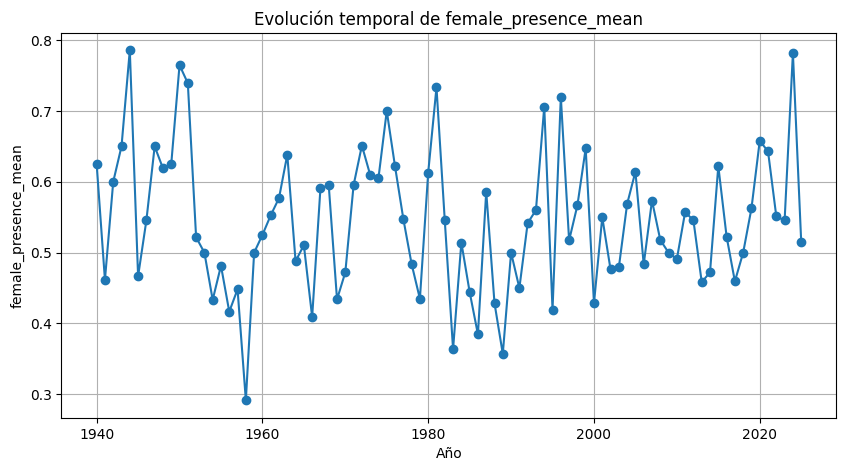

In [532]:
plt.figure(figsize=(10,5))
plt.plot(series_bin.index, series_bin.values, marker="o")
plt.xlabel("Año")
plt.ylabel("female_presence_mean")
plt.title("Evolución temporal de female_presence_mean")
plt.grid(True)
plt.show()

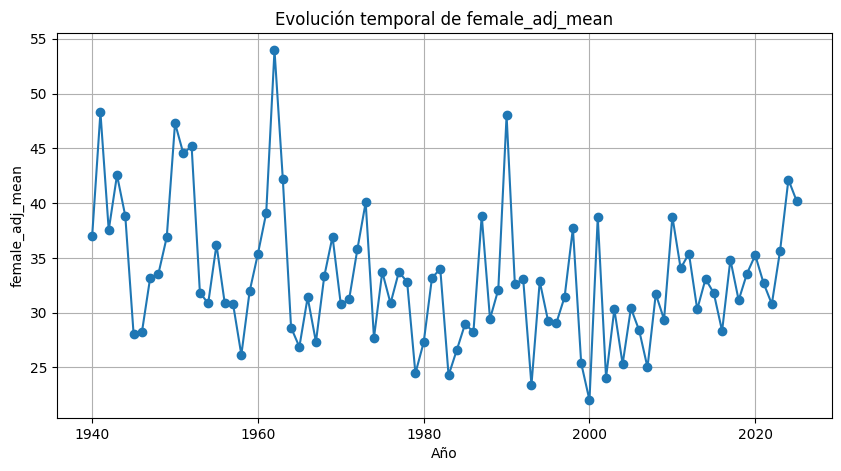

In [533]:
plt.figure(figsize=(10,5))
plt.plot(series_adj.index, series_adj.values, marker="o")
plt.xlabel("Año")
plt.ylabel("female_adj_mean")
plt.title("Evolución temporal de female_adj_mean")
plt.grid(True)
plt.show()

Vemos que no existe un patrón regular que se repita en intervalos fijos. Hay años en los que la presencia femenina parece mayor y otros en los que baja, sin una tendencia estable o progresiva.

### **3. AUTOCORRELACIÓN (ACF) / AUTOCORRELACIÓN PARCIAL (PACF)**

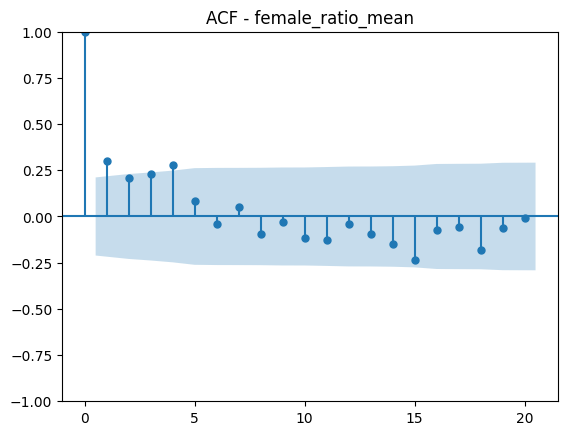

In [534]:
plot_acf(series_ratio.dropna(), lags=min(20, len(series_ratio)-1)) # examina correlaciones hasta 20 años atrás
plt.title("ACF - female_ratio_mean")
plt.show()

Se observa una dependencia a corto plazo débil: los valores de un año presentan una ligera correlación con los de los 1 a 4 años anteriores, con picos positivos de baja significancia estadística. Esto sugiere que un valor
q=4 podría considerarse como una aproximación inicial para el componente de media móvil (MA) del modelo.

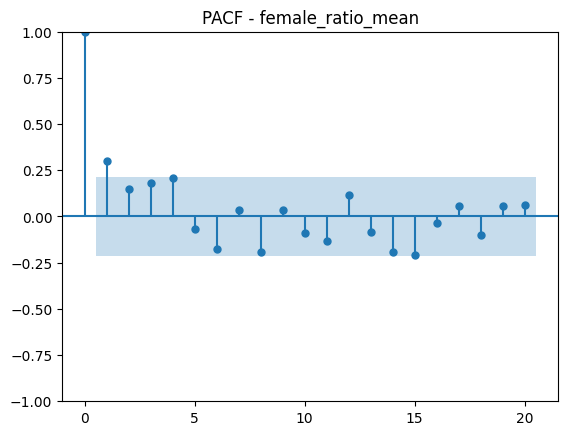

In [535]:
plot_pacf(series_ratio.dropna(), lags=min(20, len(series_ratio)-1), method='ols')
plt.title("PACF - female_ratio_mean")
plt.show()

 El primer lag es el único que sobresale con claridad y fuerza por encima de la banda de significancia. Aunque se observa un repunte en el cuarto año, este podría corresponder a un efecto cíclico puntual.

### **4. ADF TEST (estacionariedad) / PRUEBA DE DICKEY-FULLER**

In [536]:
from statsmodels.tsa.stattools import adfuller

series_adf = series_ratio.dropna()
series_adf.index = pd.to_datetime(series_adf.index, format="%Y")
series_adf = series_adf.asfreq("YS")

result = adfuller(
    series_adf,
    regression="c",   # constante (media distinta de 0)
    autolag="AIC"     # selección óptima de retardos
)

print("===== Test Dickey-Fuller Aumentado (ADF) =====")
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Número de lags usados: {result[2]}")
print(f"Número de observaciones: {result[3]}")
print("Valores críticos:")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

# ======================================================
# Interpretación
# ======================================================

alpha = 0.05

if result[1] < alpha:
    print("\nConclusión:")
    print("→ Se rechaza la hipótesis nula de raíz unitaria.")
    print("→ La serie es estacionaria en niveles.")
    print("→ El orden de integración es d = 0.")
else:
    print("\nConclusión:")
    print("→ No se rechaza la hipótesis nula de raíz unitaria.")
    print("→ La serie NO es estacionaria en niveles.")
    print("→ Es necesario diferenciar la serie (d ≥ 1).")


===== Test Dickey-Fuller Aumentado (ADF) =====
ADF Statistic: -4.4760
p-value: 0.0002
Número de lags usados: 1
Número de observaciones: 84
Valores críticos:
   1%: -3.5107
   5%: -2.8966
   10%: -2.5855

Conclusión:
→ Se rechaza la hipótesis nula de raíz unitaria.
→ La serie es estacionaria en niveles.
→ El orden de integración es d = 0.


Indica que la serie es estacionaria. Esto implica que la media y la varianza de la proporción de mujeres en el cine no cambian de manera drástica a lo largo del tiempo, sino que tienden a mantenerse alrededor de un promedio estable.


### **5. RETORNOS Y TENDENCIA OLS**

In [537]:
yearly["ratio_returns"] = yearly["female_ratio_mean"].pct_change()

ts_ols = series_ratio.reset_index()
ts_ols["t"] = np.arange(len(ts_ols))
X = sm.add_constant(ts_ols["t"])
ols = sm.OLS(ts_ols["female_ratio_mean"], X).fit()
print("Pendiente OLS:", ols.params["t"], "p-valor:", ols.pvalues["t"])

if ols.params["t"] > 0 and ols.pvalues["t"] < 0.05:
    print("✔ La presencia femenina aumenta y es significativa")
elif ols.params["t"] > 0:
    print("∼ Aumenta, pero NO es significativo")
else:
    print("✘ No aumenta según los datos")

Pendiente OLS: 0.0003427358335934609 p-valor: 0.27231630834847786
∼ Aumenta, pero NO es significativo


### **6. DETECCIÓN DE ANOMALÍAS**

In [538]:
'''Detecta años extraños para su vecindario temporal, es decir,
años que saltan respecto a los años inmediatamente anteriores (picos o caídas repentinas).'''

residuals = series_ratio - series_ratio.rolling(5, min_periods=1).mean()
std_res = residuals.std()

anomalies = residuals[np.abs(residuals) > 2 * std_res]
print("\nAños anómalos (residuos > 2σ):\n", anomalies)


Años anómalos (residuos > 2σ):
 date
1972-01-01    0.117210
1983-01-01   -0.108146
2020-01-01    0.110095
2025-01-01   -0.108772
Name: female_ratio_mean, dtype: float64


### **7. FILTRO DE HAMPEL (con detección de anomalías)**

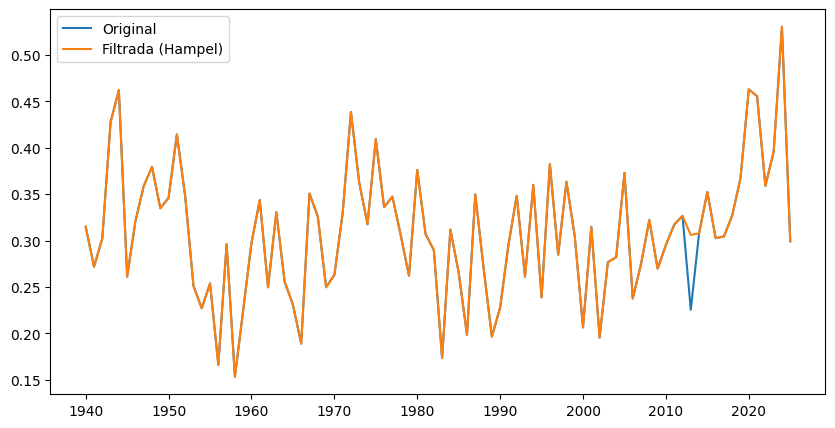

Años detectados como outliers: [Timestamp('2013-01-01 00:00:00')]


In [539]:
def hampel_filter(series, window_size=5, n_sigmas=3):
    s = series.copy()
    L = 1.4826
    for i in range(window_size, len(s) - window_size):
        window = s[i-window_size:i+window_size]
        median = window.median()
        mad = L * np.median(np.abs(window - median))
        if mad == 0:
            continue
        threshold = n_sigmas * mad
        if np.abs(s.iloc[i] - median) > threshold:
            s.iloc[i] = median
    return s

serie_hampel = hampel_filter(series_ratio, window_size=5, n_sigmas=3)

# Outliers detectados (elementos distintos entre original y filtrada)
outliers_hampel = series_ratio[series_ratio != serie_hampel]

plt.figure(figsize=(10,5))
plt.plot(series_ratio, label="Original")
plt.plot(serie_hampel, label="Filtrada (Hampel)")
plt.legend()
plt.show()

print("Años detectados como outliers:", outliers_hampel.index.tolist())


El filtro de Hampel es un método robusto para la detección de valores atípicos basado en la mediana y la Median Absolute Deviation (MAD). En este caso se aplicó una ventana de 5 años y un umbral de 3 desviaciones MAD, evaluando cada punto en función del comportamiento local de su vecindario temporal.

El filtro, además, reemplaza ese valor por la mediana local, suavizando así su contribución al análisis y evitando que un dato atípico pueda distorsionar modelos posteriores como ARIMA, SARIMAX o Prophet.

### **8. TRAIN/TEST SPLIT**

Se establecen los periodos de train y test. No se utiliza el suavizado del filtro de Hampel porque el outlier detectado no es una anomalía estadística, sino que refleja el colapso de la industria cinematográfica española ese año.

In [540]:
ts = series_ratio
ts.index = pd.to_datetime(ts.index, format="%Y")
ts = ts.asfreq("YS")

train = ts.loc[:'2015']
test = ts.loc['2016':]

### **9. DESCOMPOSICIÓN ESTACIONAL**

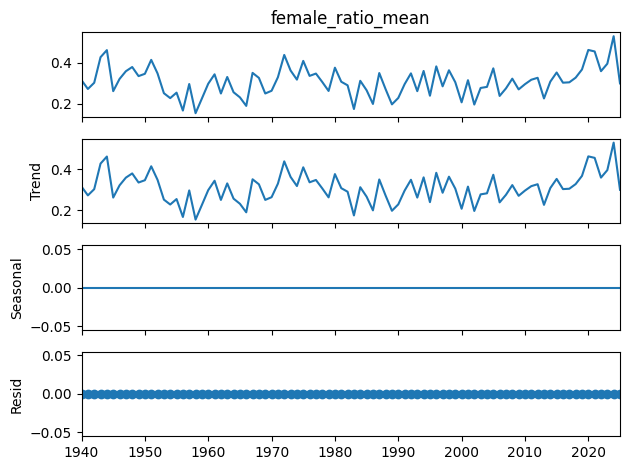

In [541]:
decomp = seasonal_decompose(ts, model='additive', period=1)
decomp.plot()
plt.show()

- Tendencia
La componente de tendencia varía claramente con el tiempo (subidas en los 70, estabilización, aumento en años recientes) y representa ciclos de representatividad que retornan a la media, lo cual justifica el uso de modelos AR(1) que capturan la memoria de estos ciclos sin alterar la serie original.

- Estacionalidad
El componente estacional aparece como una línea casi plana en torno a cero, lo que indica que no hay patrones que se repitan de forma regular en periodos fijos, sino que los cambios se explican sobre todo por la tendencia de largo plazo.
- Residuo
El residuo que muestra la descomposición es pequeño, sin cambios claros de varianza ni tendencias, lo que es consistente con un ruido aproximadamente estacionario alrededor de cero.


### **10. MODELOS CLÁSICOS DE SERIES TEMPORALES**

#### *ARIMA*


Seleccionamos la configuración del modelo que vamos a implementar mediante una evaluación iterativa de diferentes combinaciones de hiperparámetros (p, d, q). En función de sus métricas de calidad, AIC y BIC, ordenadas de forma ascendente según el criterio de Akaike (AIC),identificamos la mejor opción.

In [542]:
# Lista de combinaciones (p,d,q) optimizada según ACF/PACF
candidatos = [
    (1,0,0), (4,0,0),             # AR puros (basado en PACF)
    (0,0,1), (0,0,4),             # MA puros (basado en ACF)
    (1,0,1), (1,0,4), (4,0,1),    # Modelos mixtos sugeridos
    (4,0,4),                      # El modelo más complejo (riesgo de sobreajuste)
    (1,1,1), (1,1,4), (0,1,1),    # Versiones con diferenciación (d=1) por si no es estacionaria
    (0,0,0)                       # El modelo nulo (benchmark de ruido blanco)
]
resultados = []
for (p,d,q) in candidatos:
    try:
        modelo = ARIMA(train, order=(p,d,q)).fit()
        resultados.append((p, d, q, modelo.aic, modelo.bic))
    except:
        resultados.append((p, d, q, None, None))
resultados_ordenados = sorted(resultados, key=lambda x: float('inf') if x[3] is None else x[3])
for r in resultados_ordenados:
    print(f"ARIMA({r[0]},{r[1]},{r[2]})  ->  AIC={r[3]:.2f}   BIC={r[4]:.2f}")

ARIMA(0,0,4)  ->  AIC=-197.72   BIC=-183.74
ARIMA(1,0,0)  ->  AIC=-197.34   BIC=-190.35
ARIMA(1,0,1)  ->  AIC=-196.99   BIC=-187.66
ARIMA(0,0,1)  ->  AIC=-196.86   BIC=-189.87
ARIMA(0,0,0)  ->  AIC=-196.47   BIC=-191.81
ARIMA(1,0,4)  ->  AIC=-196.07   BIC=-179.76
ARIMA(4,0,0)  ->  AIC=-195.48   BIC=-181.49
ARIMA(4,0,1)  ->  AIC=-193.54   BIC=-177.23
ARIMA(4,0,4)  ->  AIC=-192.13   BIC=-168.82
ARIMA(0,1,1)  ->  AIC=-190.36   BIC=-185.73
ARIMA(1,1,1)  ->  AIC=-189.78   BIC=-182.83
ARIMA(1,1,4)  ->  AIC=-185.45   BIC=-171.55


ARIMA(0,0,4) - MAE: 0.08158371273325833 RMSE: 0.11040161569987975


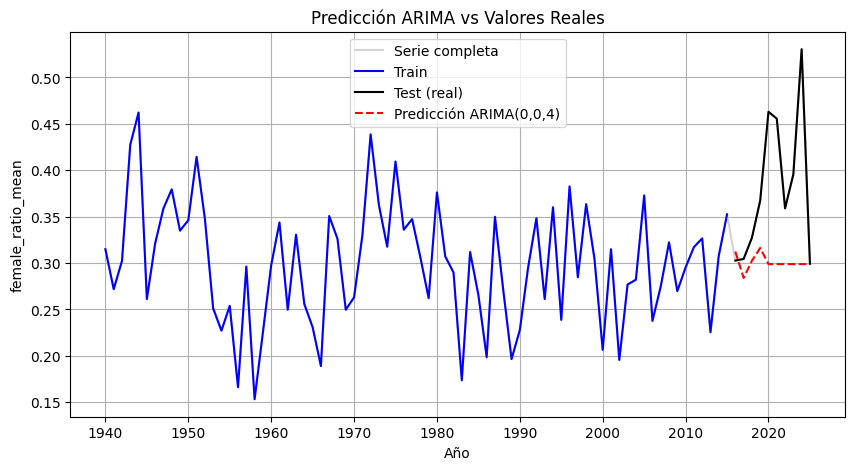

In [543]:
# Mejor modelo ARIMA según AIC
model_arima = ARIMA(train, order=(0,0,4)).fit()
pred_arima = model_arima.forecast(steps=len(test))
pred_arima.index = test.index

mae_arima = mean_absolute_error(test, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test, pred_arima))
print("ARIMA(0,0,4) - MAE:", mae_arima, "RMSE:", rmse_arima)

plt.figure(figsize=(10,5))
plt.plot(ts, label="Serie completa", color="lightgray")
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test (real)", color="black")
plt.plot(pred_arima, label="Predicción ARIMA(0,0,4)", linestyle="--", color="red")
plt.title("Predicción ARIMA vs Valores Reales")
plt.xlabel("Año")
plt.ylabel("female_ratio_mean")
plt.legend()
plt.grid(True)
plt.show()


ARIMA(1,0,0) - MAE: 0.0816373370238039 RMSE: 0.11121343310059312


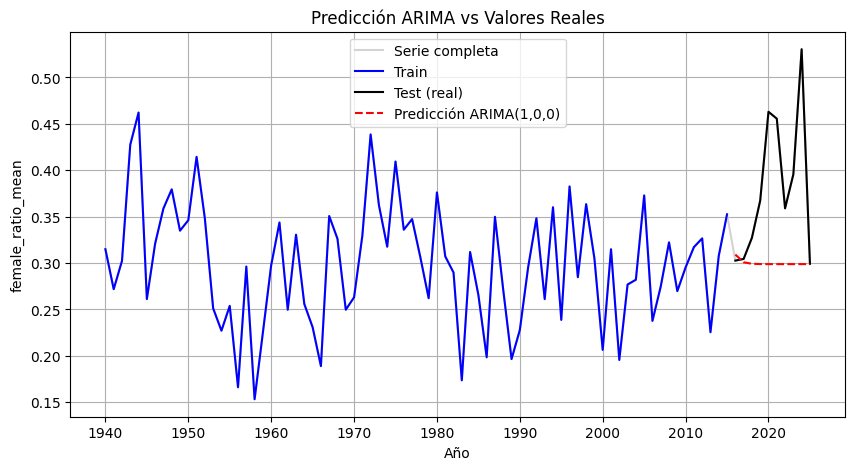

In [544]:
# Mejor modelo ARIMA según BIC
model_arima = ARIMA(train, order=(1,0,0)).fit()
pred_arima = model_arima.forecast(steps=len(test))
pred_arima.index = test.index

mae_arima = mean_absolute_error(test, pred_arima)
rmse_arima = np.sqrt(mean_squared_error(test, pred_arima))
print("ARIMA(1,0,0) - MAE:", mae_arima, "RMSE:", rmse_arima)

plt.figure(figsize=(10,5))
plt.plot(ts, label="Serie completa", color="lightgray")
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test (real)", color="black")
plt.plot(pred_arima, label="Predicción ARIMA(1,0,0)", linestyle="--", color="red")
plt.title("Predicción ARIMA vs Valores Reales")
plt.xlabel("Año")
plt.ylabel("female_ratio_mean")
plt.legend()
plt.grid(True)
plt.show()

En estadística, si dos modelos explican los datos casi igual de bien, siempre se elige el más sencillo. Aunque el (0,0,4) tiene un AIC ligeramente mejor, la diferencia es pequeña. Sin embargo, el BIC (que penaliza más la complejidad) y los errores MAE/RMSE dan mejores resultados con (1, 0, 0). Por este motivo se sigue el estudio con esta combinación.

In [545]:
# Detección de anomalías usando residuos del modelo
residuals_arima = test - pred_arima
std_arima = residuals_arima.std()
anomalies_arima = residuals_arima[abs(residuals_arima) > 2 * std_arima]

print("\nPosibles años anómalos según ARIMA(1,0,0):")
print(anomalies_arima)


Posibles años anómalos según ARIMA(1,0,0):
date
2020-01-01    0.164164
2024-01-01    0.231626
dtype: float64


#### *HOLT-WINTERS*

Holt-Winters - MAE: 0.08328973343274672 RMSE: 0.11282841074762931


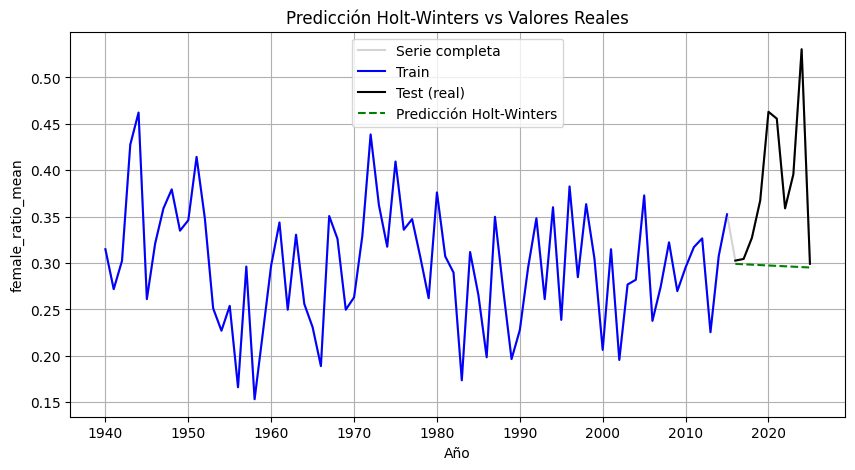

In [546]:
hw_model = ExponentialSmoothing(train, trend="add", seasonal=None).fit()
pred_hw = hw_model.forecast(len(test))
pred_hw.index = test.index

mae_hw = mean_absolute_error(test, pred_hw)
rmse_hw = np.sqrt(mean_squared_error(test, pred_hw))
print("Holt-Winters - MAE:", mae_hw, "RMSE:", rmse_hw)

plt.figure(figsize=(10,5))
plt.plot(ts, label="Serie completa", color="lightgray")
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test (real)", color="black")
plt.plot(pred_hw, label="Predicción Holt-Winters", linestyle="--", color="green")
plt.title("Predicción Holt-Winters vs Valores Reales")
plt.xlabel("Año")
plt.ylabel("female_ratio_mean")
plt.legend()
plt.grid(True)
plt.show()


In [547]:
# Detección de anomalías usando residuos del modelo
residuals_hw = test - pred_hw
std_hw = residuals_hw.std()
anomalies_hw = residuals_hw[abs(residuals_hw) > 2 * std_hw]

print("\nPosibles años anómalos según Holt-Lineal:")
print(anomalies_hw)


Posibles años anómalos según Holt-Lineal:
date
2020-01-01    0.165641
2024-01-01    0.234822
dtype: float64


#### *SARIMAX con exógena*

Con el objetivo de enriquecer el modelo (pasando de ARIMA a SARIMAX), se prueba con la exógena 'female_adj_percentaje' al ser la variable más relacionada con nuestro indicador base 'female_ratio_mean'.

In [548]:
y = serie_hampel.dropna()
y.index = pd.to_datetime(y.index, format="%Y")
y = y.asfreq("YS")

exog_full = yearly["female_adj_mean"]
common_index = y.index.intersection(exog_full.index)
y = y.loc[common_index]
exog_full = exog_full.loc[common_index]

train_y = y.loc[:'2015']
test_y  = y.loc['2016':]

train_exog = exog_full.loc[:'2015']
test_exog  = exog_full.loc['2016':]

print("--- Dimensiones ---")
print(f"Train Y: {train_y.shape}")
print(f"Train Exog: {train_exog.shape}")
print(f"Test Y: {test_y.shape}")
print(f"Test Exog: {test_exog.shape}")


--- Dimensiones ---
Train Y: (76,)
Train Exog: (76,)
Test Y: (10,)
Test Exog: (10,)


In [549]:
# SARIMAX
sarimax_model = SARIMAX(
    train_y,
    exog=train_exog,
    order=(1,0,0),
    seasonal_order=(0,0,0,0)
)

sarimax_fit = sarimax_model.fit(disp=False)

# Predicción
pred_sarimax = sarimax_fit.predict(
    start=test_y.index[0],       # Primera fecha del test
    end=test_y.index[-1],        # Última fecha del test
    exog=test_exog
)


--- RESULTADOS SARIMAX con exógena ---
MAE: 0.0873
RMSE: 0.1023
                               SARIMAX Results                                
Dep. Variable:      female_ratio_mean   No. Observations:                   76
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  98.742
Date:                Thu, 18 Dec 2025   AIC                           -191.484
Time:                        20:53:31   BIC                           -184.492
Sample:                    01-01-1940   HQIC                          -188.690
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
female_adj_mean     0.0088      0.000     29.095      0.000       0.008       0.009
ar.L1               0.2832      0.144      1.973   

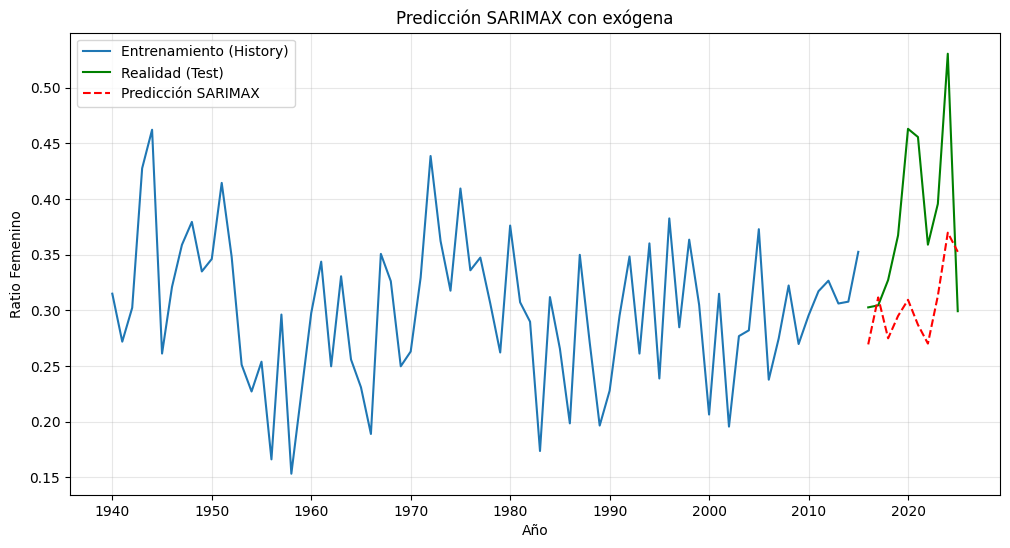

In [550]:
mae_sarimax = mean_absolute_error(test_y, pred_sarimax)
rmse_sarimax = np.sqrt(mean_squared_error(test_y, pred_sarimax))

print("\n--- RESULTADOS SARIMAX con exógena ---")
print(f"MAE: {mae_sarimax:.4f}")
print(f"RMSE: {rmse_sarimax:.4f}")
print(sarimax_fit.summary())

plt.figure(figsize=(12, 6))
plt.plot(train_y.index, train_y, label="Entrenamiento (History)")
plt.plot(test_y.index, test_y, label="Realidad (Test)", color='green')
plt.plot(pred_sarimax.index, pred_sarimax, label="Predicción SARIMAX", color='red', linestyle='--')

plt.title("Predicción SARIMAX con exógena")
plt.xlabel("Año")
plt.ylabel("Ratio Femenino")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Como se observa en la gráfica, la predicción (línea roja discontinua) intenta seguir la tendencia pero reduce la magnitud de los picos. Esto sugiere que, aunque la variable exógena aporta información sobre la dirección, la configuración actual del modelo (1,0,0) no captura la intensidad del cambio de la serie.

#### *COMPARACIÓN*

In [551]:
comparacion = pd.DataFrame({
    "Modelo": ["ARIMA(1,0,0)", "Holt-Winters (Holt lineal)", "SARIMAX + exógena"],
    "MAE": [mae_arima, mae_hw, mae_sarimax],
    "RMSE": [rmse_arima, rmse_hw, rmse_sarimax]
})

print("\n=== Comparación de Errores ===\n")
print(comparacion.to_string(index=False))


=== Comparación de Errores ===

                    Modelo      MAE     RMSE
              ARIMA(1,0,0) 0.081637 0.111213
Holt-Winters (Holt lineal) 0.083290 0.112828
         SARIMAX + exógena 0.087296 0.102261


Los resultados obtenidos muestran que el modelo ARIMA presenta el menor error promedio absoluto, mientras que el modelo SARIMAX con una exógena obtiene el menor error cuadrático medio raíz.

En conjunto, los resultados confirman que la representación femenina en las películas no sigue un patrón estable o predecible.

### **11. HETEROCEDASTICIDAD ARCH**

In [552]:
returns = series_ratio.diff().dropna()
returns_sq = returns**2

arch_test = het_arch(returns_sq)
print("p-value ARCH:", arch_test[1])
if arch_test[1] < 0.05:
    print("Existe heterocedasticidad → ARCH/GARCH puede ser útil")
else:
    print("No hay heterocedasticidad significativa")

p-value ARCH: 0.7127309702238237
No hay heterocedasticidad significativa


### **12. MODELOS AVANZADOS**

#### *LSTM*

LSTM - MAE: 0.0846312801077708
LSTM - RMSE: 0.11434387605259426


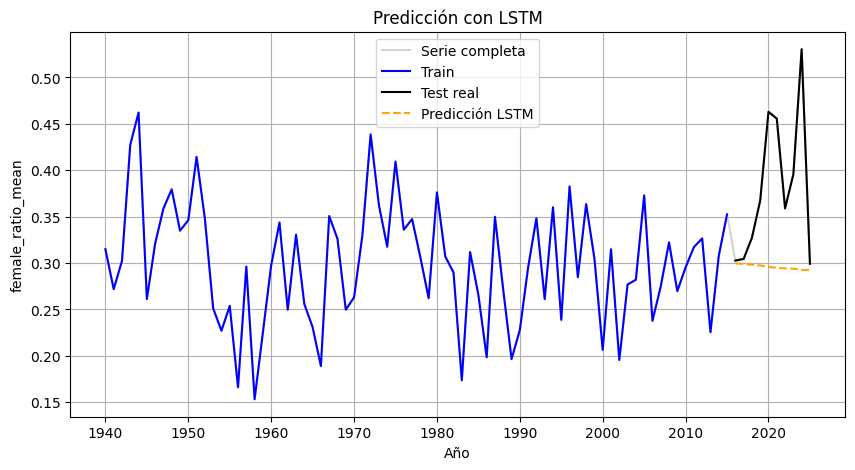

In [553]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled  = scaler.transform(test.values.reshape(-1,1))
n_input = 10

generator = TimeseriesGenerator(
    train_scaled,
    train_scaled,
    length=n_input,
    batch_size=1
)
model_lstm = Sequential()
model_lstm.add(LSTM(32, activation="tanh", input_shape=(n_input,1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss="mse")

model_lstm.fit(generator, epochs=30, verbose=0)
test_predictions = []

current_batch = train_scaled[-n_input:].reshape((1, n_input, 1))

for _ in range(len(test)):
    pred = model_lstm.predict(current_batch, verbose=0)[0]
    test_predictions.append(pred)
    current_batch = np.append(
        current_batch[:,1:,:],
        [[pred]],
        axis=1
    )
fc_lstm = scaler.inverse_transform(
    np.array(test_predictions).reshape(-1,1)
).flatten()

fc_lstm = pd.Series(fc_lstm, index=test.index)
mae_lstm = mean_absolute_error(test, fc_lstm)
rmse_lstm = np.sqrt(mean_squared_error(test, fc_lstm))

print("LSTM - MAE:", mae_lstm)
print("LSTM - RMSE:", rmse_lstm)

plt.figure(figsize=(10,5))
plt.plot(ts.index, ts.values, label="Serie completa", color="lightgray")
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Test real", color="black")
plt.plot(fc_lstm.index, fc_lstm, "--", label="Predicción LSTM", color="orange")
plt.title("Predicción con LSTM")
plt.xlabel("Año")
plt.ylabel("female_ratio_mean")
plt.grid(True)
plt.legend()
plt.show()


Hemos probado un modelo más avanzado, LSTM, implementando una red neuronal recurrente. El entrenamiento se estructura mediante ventanas deslizantes y para la fase de validación, se utiliza una estrategia de predicción recursiva.

En la gráfica resultante, observamos una curva de predicción suave (línea naranja) que falla al capturar la volatilidad y el pico ascendente de los datos reales (línea negra).

#### **13. AUTO-ARIMA**

Ante la dificultad de los modelos anteriores para capturar la realidad, implementamos el algoritmo auto_arima.

Como las series temporales requieren datos numéricos y consistencia temporal, el sentimiento se transforma en una escala numérica ordinal y los géneros se convierten en indicadores de frecuencia anual (porcentajes) mediante one-hot encoding.
Los datos se agregan por año para alinear la frecuencia de los predictores y generamos un ranking de correlación de Pearson, para ver que variables tienen más relación con la variable objetivo y poder usarlas como exógenas obteniendo mejores resultados.

In [554]:
sentiment_map = {'POS': 1, 'NEU': 0, 'NEG': -1}
df['sentiment_score'] = df['media_sentiment'].map(sentiment_map)

cols_numericas = ['female_adj_percentage', 'duration_minutes', 'word_plot_count', 'female_ratio', 'sentiment_score']

# Pasar columna de género a dummies
df_processed = pd.get_dummies(
    df,
    columns=['genre_simplified'],
    prefix=['pct']
)

# Seleccionar columnas para agregar: las numéricas + las dummies de género creadas
cols_to_agg = cols_numericas + [col for col in df_processed.columns if col.startswith('pct_')]

df_anual_completo = df_processed.groupby('year')[cols_to_agg].mean() # Agrupación anual (Calcula el promedio del score de sentimiento también)

df_anual_completo.index = pd.to_datetime(df_anual_completo.index, format="%Y")
df_anual_completo = df_anual_completo.asfreq("YS")

# Renombrar columnas
df_anual_completo = df_anual_completo.rename(columns={
    'female_ratio': 'female_ratio_mean',
    'female_adj_percentage': 'female_adj_mean',
    'sentiment_score': 'sentiment_score_mean'
})

# Correlación
ranking = df_anual_completo.corr()['female_ratio_mean'].sort_values(ascending=False)

print("--- RANKING DE VARIABLES EXÓGENAS ---")
ranking

--- RANKING DE VARIABLES EXÓGENAS ---


,female_ratio_mean
female_ratio_mean,1.000000
female_adj_mean,0.361618
pct_Suspenso,0.174975
word_plot_count,0.168232
pct_Terror,0.158020
sentiment_score_mean,0.124812
duration_minutes,0.111751
pct_Histórico,0.107145
pct_Drama,0.100364
pct_Documental,0.059619


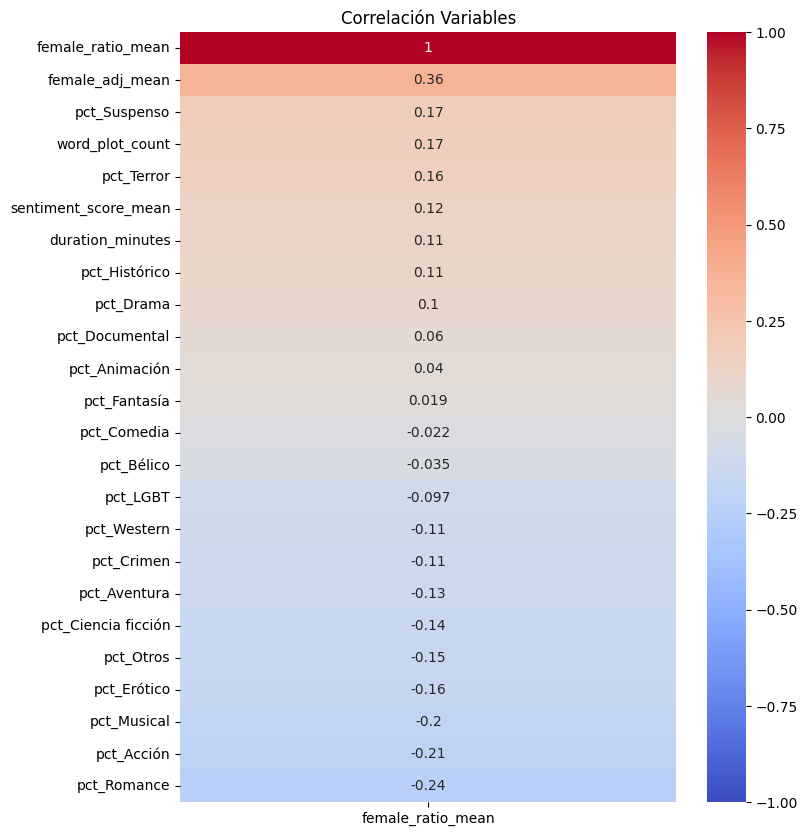

In [555]:
plt.figure(figsize=(8, 10))
sns.heatmap(ranking.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlación Variables")
plt.show()

In [556]:
# Excluir female_ratio_mean de la lista
ranking_exog = ranking.drop(labels=['female_ratio_mean'])

# Seleccionar top 3 exógenas por correlación absoluta
top3_exog = ranking_exog.abs().sort_values(ascending=False).head(3).index.tolist()

print("Top 3 variables exógenas más correladas:", top3_exog)

Top 3 variables exógenas más correladas: ['female_adj_mean', 'pct_Romance', 'pct_Acción']


Finalmente, se van a seleccionar un subconjunto de tres variables exógenas para aplicar el modelo auto:

- female_adj_mean: Mantiene la correlación más alta y consistente alineándose directamente con la tendencia de la variable objetivo.

- pct_Romance: Presenta una correlación negativa de -0.24. Esto indica que los años con mayor peso del género romance se asocian con niveles más bajos en el ratio de representación femenina analizado.

- pct_Action: Con una correlación negativa de -0.21, refuerza la tendencia observada en el romance.

Se ha considerado que los géneros de Acción y Romance aportan información similar y no va a enriquecer el modelo. Se ha seleccionado la variable sentiment_score_mean para complementar.

In [566]:
var_exogenas = [
    'female_adj_mean',
    'pct_Romance',
    'sentiment_score_mean'
]

exog_anual =df_anual_completo[var_exogenas]

# Serie temporal con outliers suavizados
y = serie_hampel.dropna().copy()
y.index = pd.to_datetime(y.index, format="%Y")
y = y.asfreq("YS")

common_index = y.index.intersection(exog_anual.index)
y = y.loc[common_index]
exog_anual = exog_anual.loc[common_index]

# Dividir en train y test
train_y = y.loc[:'2015']
test_y  = y.loc['2016':]

train_exog = exog_anual.loc[:'2015']
test_exog  = exog_anual.loc['2016':]

print("--- Dimensiones ---")
print(f"Train Y: {len(train_y)} | Train Exog: {train_exog.shape}")
print(f"Test Y:  {len(test_y)} | Test Exog:  {test_exog.shape}")

--- Dimensiones ---
Train Y: 76 | Train Exog: (76, 3)
Test Y:  10 | Test Exog:  (10, 3)



Buscando el mejor modelo...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-185.004, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-188.291, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-189.020, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-187.116, Time=0.58 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-187.112, Time=0.82 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-185.042, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-206.498, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-205.712, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-204.213, Time=0.76 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-204.881, Time=2.68 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-206.811, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-204.481, Time=1.26 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-199.636, Time=0.66 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 9.613 s

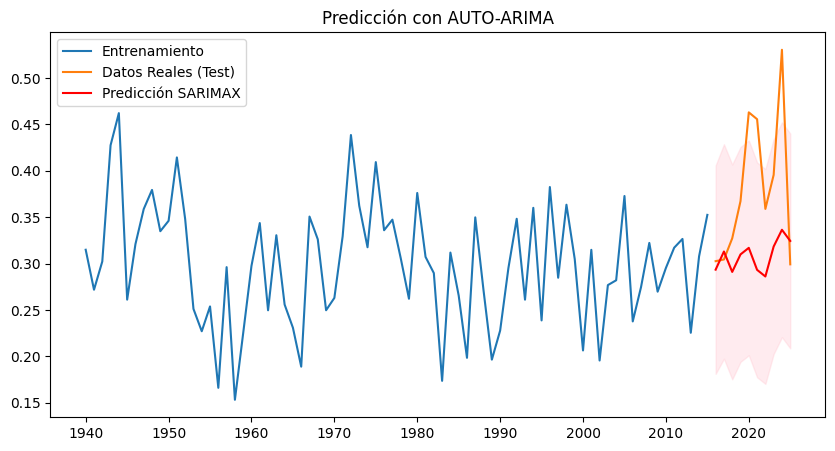

In [568]:
print("\nBuscando el mejor modelo...")

model_auto = pm.auto_arima(
    y=train,
    X=train_exog,  # ahora usa las 3 exógenas
    start_p=0,
    start_q=0,
    max_p=6,
    max_q=6,
    d=0, # Forzar a 0 para evitar sobreajuste
    seasonal=False,
    stepwise=True,
    test="adf",
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)


print(model_auto.summary())

# Predicción
prediction, conf_int = model_auto.predict(
    n_periods=len(test),
    X=test_exog,
    return_conf_int=True
)

plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Entrenamiento")
plt.plot(test.index, test, label="Datos Reales (Test)")
plt.plot(test.index, prediction, label="Predicción SARIMAX", color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title("Predicción con AUTO-ARIMA")
plt.legend()
plt.show()

In [569]:
pred = np.array(prediction)
true = np.array(test)

mae_auto = mean_absolute_error(true, pred)
rmse_auto = mean_squared_error(true, pred)

print("\nAUTO-ARIMA")
print("MAE:", mae_auto)
print("RMSE:", rmse_auto)


AUTO-ARIMA
MAE: 0.07890933164624972
RMSE: 0.010200450291047134


Como se había calculado previamente, el mejor modleo es SARIMAX(1,0,0). Obervamos una mejora en el rendimiento predictivo tras la inclusión de variables exógenas.
A continuación vamos a ejecutar una evaluación probando distintas permutaciones de las variables candidatas (female_adj_mean, pct_Romance, sentiment_score_mean) en conjunto con los hiperparámetros del modelo SARIMAX.

#### **Pruebas SARIMAX con distintas variables exogenás**


--- Calculando Modelo Base ARIMA (1,0,0) ---
Modelando: SARIMAX(1,0,0) + female_adj_mean
Modelando: SARIMAX(1,0,0) + pct_Romance
Modelando: SARIMAX(1,0,0) + sentiment_score_mean
Modelando: SARIMAX(1,0,0) + female_adj_mean + pct_Romance
Modelando: SARIMAX(1,0,0) + female_adj_mean + sentiment_score_mean
Modelando: SARIMAX(1,0,0) + pct_Romance + sentiment_score_mean
Modelando: SARIMAX(1,0,0) + Todas_las_3


=== COMPARACIÓN FINAL (ORDENADO POR MEJOR MAE) ===

                                                 Modelo      MAE     RMSE  P-valor Mín. Exógena
                           SARIMAX(1,0,0) + Todas_las_3 0.085644 0.100266         5.725557e-145
         SARIMAX(1,0,0) + female_adj_mean + pct_Romance 0.085828 0.100239         7.663637e-197
SARIMAX(1,0,0) + female_adj_mean + sentiment_score_mean 0.087034 0.102270         9.720594e-145
                       SARIMAX(1,0,0) + female_adj_mean 0.087296 0.102261         4.144997e-186
                           SARIMAX(1,0,0) + pct_Romance 0.0

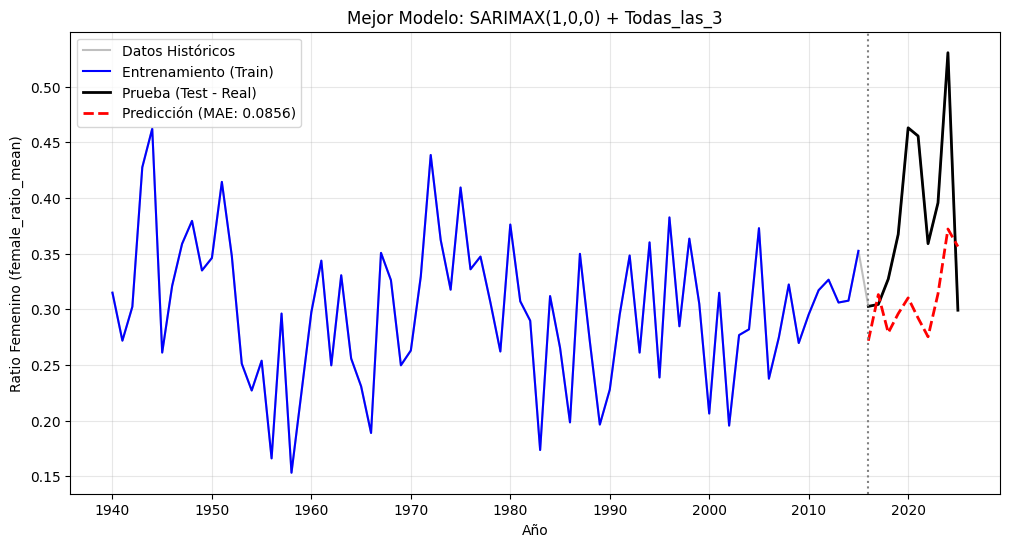

In [560]:
y = serie_hampel.dropna().copy()
y.index = pd.to_datetime(y.index, format="%Y")
y = y.asfreq("YS")

# Alineamiento con exógenas
common_index = y.index.intersection(df_anual_completo.index)
y = y.loc[common_index]
exog_anual = df_anual_completo.loc[common_index]

train_y = y.loc[:'2015']
test_y  = y.loc['2016':]

train_exog = exog_anual.loc[:'2015']
test_exog  = exog_anual.loc['2016':]

target_exog = ['female_adj_mean', 'pct_Romance', 'sentiment_score_mean']

individual_vars = {}

# Individuales
for col in target_exog:
    individual_vars[f"{col}"] = [col]

# Pares
for combo in combinations(target_exog, 2):
    name = " + ".join(combo)
    individual_vars[name] = list(combo)

# Triple (todas juntas)
individual_vars["Todas_las_3"] = target_exog


results_all_models = []
model_orders = {
    "(1,0,0)": None
}

for order_name, _ in model_orders.items():
    p, d, q = map(int, order_name.strip("()").split(','))

    # Modelo base ARIMA sin exógenas
    print(f"\n--- Calculando Modelo Base ARIMA {order_name} ---")
    try:
        base_model = SARIMAX(train_y, order=(p,d,q), seasonal_order=(0,0,0,0)).fit(disp=False)
        pred_base = base_model.predict(start=len(train_y), end=len(train_y) + len(test_y) - 1)
        pred_base.index = test_y.index

        mae_base = mean_absolute_error(test_y, pred_base)
        rmse_base = np.sqrt(mean_squared_error(test_y, pred_base))

        results_all_models.append({
            "Modelo": f"ARIMA{order_name} - Base",
            "p,d,q": order_name,
            "Key_Exog": "Base", # Identificador interno
            "MAE": mae_base,
            "RMSE": rmse_base,
            "P-valor Mín. Exógena": None
        })
    except Exception as e:
        print(f"Error en base {order_name}: {e}")

    # SARIMAX con combinaciones específicas
    for var_name, columns in individual_vars.items():
        print(f"Modelando: SARIMAX{order_name} + {var_name}")

        train_exog_single = train_exog[columns]
        test_exog_single  = test_exog[columns]

        try:
            model_sarimax = SARIMAX(
                train_y,
                order=(p,d,q),
                seasonal_order=(0,0,0,0),
                exog=train_exog_single
            ).fit(disp=False)

            pred_sarimax = model_sarimax.predict(
                start=test_y.index[0],
                end=test_y.index[-1],
                exog=test_exog_single
            )
            pred_sarimax.index = test_y.index

            mae = mean_absolute_error(test_y, pred_sarimax)
            rmse = np.sqrt(mean_squared_error(test_y, pred_sarimax))

            # Obtener p-valor mínimo de las exógenas para referencia
            p_values_exog = model_sarimax.pvalues[columns]
            min_p_value = p_values_exog.min() if not p_values_exog.empty else None

            results_all_models.append({
                "Modelo": f"SARIMAX{order_name} + {var_name}",
                "p,d,q": order_name,
                "Key_Exog": var_name, # Guardamos la key del diccionario para recuperarla luego
                "MAE": mae,
                "RMSE": rmse,
                "P-valor Mín. Exógena": min_p_value
            })

        except Exception as e:
            print(f"ERROR en {var_name}: {e}")

results_df_final = pd.DataFrame(results_all_models)
# Convertir P-valor a float para visualización limpia
results_df_final['P-valor Mín. Exógena'] = results_df_final['P-valor Mín. Exógena'].astype(float)
print("\n\n=== COMPARACIÓN FINAL (ORDENADO POR MEJOR MAE) ===\n")
# Ordenamos por MAE ascendente
display_cols = ["Modelo", "MAE", "RMSE", "P-valor Mín. Exógena"]
print(results_df_final.sort_values(by="MAE")[display_cols].to_string(index=False))
# SELECCIÓN DEL MEJOR MODELO POR MAE
best_model_idx = results_df_final['MAE'].idxmin()
best_model_row = results_df_final.loc[best_model_idx]

print("\n------------------------------------------------")
print("MEJOR MODELO SELECCIONADO (Menor MAE):")
print(f"Modelo: {best_model_row['Modelo']}")
print(f"MAE:    {best_model_row['MAE']:.6f}")
print(f"RMSE:   {best_model_row['RMSE']:.6f}")
print("------------------------------------------------")

best_order_str = best_model_row["p,d,q"]
p, d, q = map(int, best_order_str.strip("()").split(','))
key_exog = best_model_row["Key_Exog"]

# Configurar exógenas del ganador
if key_exog == "Base":
    exog_train_final = None
    exog_test_final = None
else:
    cols_ganadoras = individual_vars[key_exog]
    exog_train_final = train_exog[cols_ganadoras]
    exog_test_final  = test_exog[cols_ganadoras]

# Ajustar modelo final
model_best = SARIMAX(
    train_y,
    order=(p,d,q),
    seasonal_order=(0,0,0,0),
    exog=exog_train_final
).fit(disp=False)

pred_best = model_best.predict(
    start=test_y.index[0],
    end=test_y.index[-1],
    exog=exog_test_final
)
pred_best.index = test_y.index

# Métricas del mejor modelo
mae_best_sarimax = mean_absolute_error(test_y, pred_best)
rmse_best_sarimax = np.sqrt(mean_squared_error(test_y, pred_best))

# Gráfico
plt.figure(figsize=(12,6))
plt.plot(y.index, y.values, label="Datos Históricos", color="gray", alpha=0.5)
plt.plot(train_y.index, train_y.values, label="Entrenamiento (Train)", color="blue")
plt.plot(test_y.index, test_y.values, label="Prueba (Test - Real)", color="black", linewidth=2)
plt.plot(pred_best.index, pred_best.values, '--', color="red", linewidth=2, label=f"Predicción (MAE: {best_model_row['MAE']:.4f})")

plt.axvline(x=test_y.index[0], linestyle=":", color="gray")
plt.title(f"Mejor Modelo: {best_model_row['Modelo']}")
plt.xlabel("Año")
plt.ylabel("Ratio Femenino (female_ratio_mean)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### **14. FORECAST EXTENDIDO**


Generando forecast extendido de 20 años para: SARIMAX + exógenas


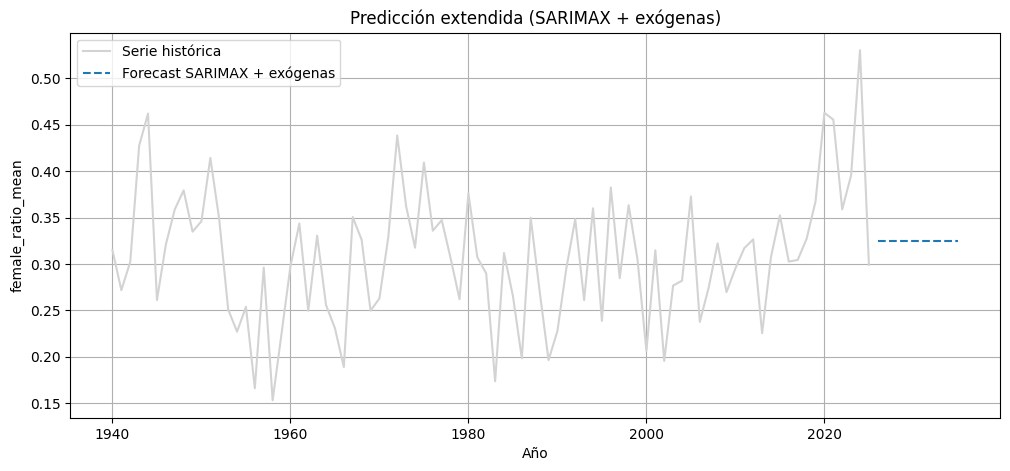

In [561]:
best_model_name = "SARIMAX + exógenas"
steps = 20
last_year = ts.index[-1].year
future_index = pd.date_range(start=f"{last_year+1}", periods=steps, freq="YS")
print(f"\nGenerando forecast extendido de {steps} años para:", best_model_name)

target_exog = ['female_adj_mean', 'pct_Romance', 'sentiment_score_mean']

# Tomamos solo las exógenas seleccionadas
last_exog_values = exog_anual[target_exog].iloc[-1]
future_exog = pd.DataFrame(
    np.tile(last_exog_values.values, (steps, 1)),
    index=future_index,
    columns=target_exog
)

# Predicción
future_forecast = model_auto.predict(n_periods=steps, X=future_exog)
future_forecast = pd.Series(future_forecast, index=future_index)

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values, label="Serie histórica", color="lightgray")
plt.plot(future_forecast.index, future_forecast.values, '--', label=f"Forecast {best_model_name}")
plt.xlabel("Año")
plt.ylabel("female_ratio_mean")
plt.title(f"Predicción extendida ({best_model_name})")
plt.grid(True)
plt.legend()
plt.show()
